In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [3]:
import polars as pl

# Training dataset

In [4]:
train_series = pl.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
train_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')

In [5]:
train_series.shape

(127946340, 5)

In [6]:
train_series.schema

OrderedDict([('series_id', Utf8),
             ('step', UInt32),
             ('timestamp', Utf8),
             ('anglez', Float32),
             ('enmo', Float32)])

In [7]:
train_series.sample(5)

series_id,step,timestamp,anglez,enmo
str,u32,str,f32,f32
"""3be1545083b7""",26275,"""2018-01-26T00:…",43.242901,0.0
"""d0f613c700f7""",358241,"""2019-05-07T10:…",-60.349602,0.0592
"""18b61dd5aae8""",279099,"""2018-01-07T20:…",52.952702,0.0391
"""8a22387617c3""",226608,"""2018-08-26T18:…",-29.851299,0.0011
"""1c7c0bad1263""",12332,"""2018-12-13T08:…",33.914001,0.0


In [8]:
# is_null в polars работает только со столбцом. 
missing_values_count = []

for column in train_series.columns:
    null_count = train_series[column].is_null().sum()
    missing_values_count.append((column, null_count))

# Вывод количества пропущенных значений в каждом столбце
for column, count in missing_values_count:
    print(f"Столбец '{column}': {count}")

Столбец 'series_id': 0
Столбец 'step': 0
Столбец 'timestamp': 0
Столбец 'anglez': 0
Столбец 'enmo': 0


In [9]:
train_series['series_id'].n_unique()

277

Количество уникальных series_id: 277

In [10]:
train_events.shape

(14508, 5)

In [11]:
train_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## Рассмотрим отдельные окна

In [12]:
train_series['timestamp'].min()

'2017-08-04T17:30:00-0400'

In [13]:
train_series['timestamp'].max()

'2019-07-09T09:44:55-0400'

У нас имеется 277 series_id с 2017-2017гг

In [14]:
top_series = (
    train_events.groupby('series_id')['event'].count()
    .sort_values(ascending=False)
    .head(5)
)

In [15]:
top_series

series_id
78569a801a38    168
f564985ab692    124
fb223ed2278c    106
f56824b503a0    100
cfeb11428dd7     94
Name: event, dtype: int64

Рассмотрим series_id у которых больше всего данных

In [16]:
top_series_index = top_series.index.to_list()


sample_series = train_series.filter(pl.col('series_id').is_in(top_series_index))


In [17]:
print(sample_series)

shape: (5_061_240, 5)
┌──────────────┬────────┬──────────────────────────┬────────────┬────────┐
│ series_id    ┆ step   ┆ timestamp                ┆ anglez     ┆ enmo   │
│ ---          ┆ ---    ┆ ---                      ┆ ---        ┆ ---    │
│ str          ┆ u32    ┆ str                      ┆ f32        ┆ f32    │
╞══════════════╪════════╪══════════════════════════╪════════════╪════════╡
│ 78569a801a38 ┆ 0      ┆ 2017-08-17T16:45:00-0400 ┆ -0.709     ┆ 0.0521 │
│ 78569a801a38 ┆ 1      ┆ 2017-08-17T16:45:05-0400 ┆ 26.1593    ┆ 0.0415 │
│ 78569a801a38 ┆ 2      ┆ 2017-08-17T16:45:10-0400 ┆ -19.0553   ┆ 0.0312 │
│ 78569a801a38 ┆ 3      ┆ 2017-08-17T16:45:15-0400 ┆ -56.735001 ┆ 0.0486 │
│ …            ┆ …      ┆ …                        ┆ …          ┆ …      │
│ fb223ed2278c ┆ 918356 ┆ 2019-02-05T15:29:40-0500 ┆ -8.2152    ┆ 0.0229 │
│ fb223ed2278c ┆ 918357 ┆ 2019-02-05T15:29:45-0500 ┆ -7.3174    ┆ 0.0258 │
│ fb223ed2278c ┆ 918358 ┆ 2019-02-05T15:29:50-0500 ┆ -10.6515   ┆ 0.0328 │
│ f

In [18]:
sample_events = train_events[train_events['series_id'].isin(top_series_index)]

In [19]:
sample_events.head()

,series_id,night,event,step,timestamp
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400


In [20]:
sample_events.shape

(592, 5)

## Поработаем с датами. 

Если проанализировать столбец с временными метками (timestamp), можно заметить, что данные в данном формате не совсем пригодны для корректного использования. Необходимо преобразовать даты из формата 2017-08-17T16:45:00-0400 в соответствующий правильный формат.

In [21]:
sample_series = sample_series.with_columns( [
  pl.col('timestamp').str.to_datetime().dt.replace_time_zone(None).alias("datetime")
])

In [22]:
sample_series


series_id,step,timestamp,anglez,enmo,datetime
str,u32,str,f32,f32,datetime[μs]
"""78569a801a38""",0,"""2017-08-17T16:…",-0.709,0.0521,2017-08-17 20:45:00
"""78569a801a38""",1,"""2017-08-17T16:…",26.1593,0.0415,2017-08-17 20:45:05
"""78569a801a38""",2,"""2017-08-17T16:…",-19.0553,0.0312,2017-08-17 20:45:10
"""78569a801a38""",3,"""2017-08-17T16:…",-56.735001,0.0486,2017-08-17 20:45:15
"""78569a801a38""",4,"""2017-08-17T16:…",-59.033001,0.035,2017-08-17 20:45:20
"""78569a801a38""",5,"""2017-08-17T16:…",-49.880402,0.0375,2017-08-17 20:45:25
"""78569a801a38""",6,"""2017-08-17T16:…",-44.805901,0.0356,2017-08-17 20:45:30
"""78569a801a38""",7,"""2017-08-17T16:…",-9.747,0.0613,2017-08-17 20:45:35
"""78569a801a38""",8,"""2017-08-17T16:…",12.684,0.0431,2017-08-17 20:45:40


In [23]:
sample_series['datetime'].dt.year().sort().unique()


datetime
i32
2017
2018
2019


In [24]:
sample_events['datetime'] = sample_events['timestamp'].astype(str).str.replace('T', ' ').str[:-5]

/tmp/ipykernel_42/288545418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_events['datetime'] = sample_events['timestamp'].astype(str).str.replace('T', ' ').str[:-5]


In [25]:
sample_events['datetime'] = pd.to_datetime(sample_events['datetime'])

/tmp/ipykernel_42/2123336767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_events['datetime'] = pd.to_datetime(sample_events['datetime'])


In [26]:
sample_events.head(5)

,series_id,night,event,step,timestamp,datetime
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400,2017-08-19 09:22:00
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400,2017-08-20 03:21:00


# Построим графики

In [27]:
import matplotlib.pyplot as plt

In [28]:
onset_events = sample_events[sample_events['event']=='onset']
wakeup_events = sample_events[sample_events['event']=='wakeup']

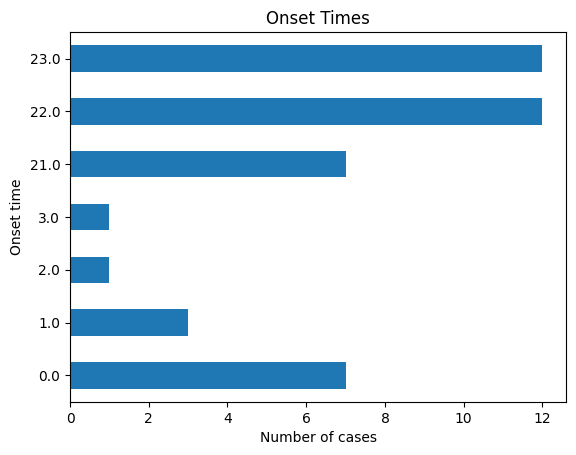

In [29]:
onset_events['datetime'].dt.hour.value_counts().sort_index().plot(kind='barh')
plt.title('Onset Times')
plt.xlabel('Number of cases')
plt.ylabel('Onset time')
plt.show()

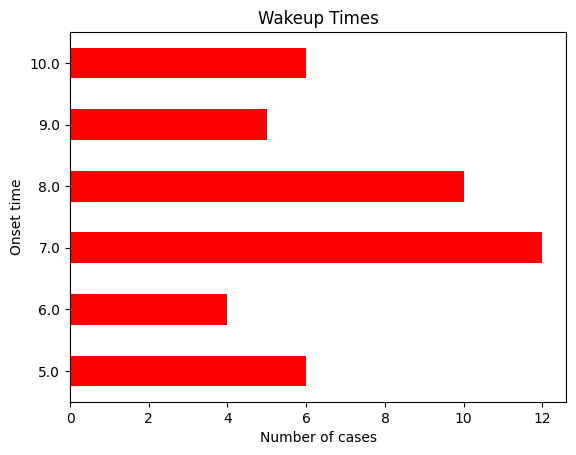

In [30]:
wakeup_events['datetime'].dt.hour.value_counts().sort_index().plot(kind='barh', color = 'red')
plt.title('Wakeup Times')
plt.xlabel('Number of cases')
plt.ylabel('Onset time')
plt.show()

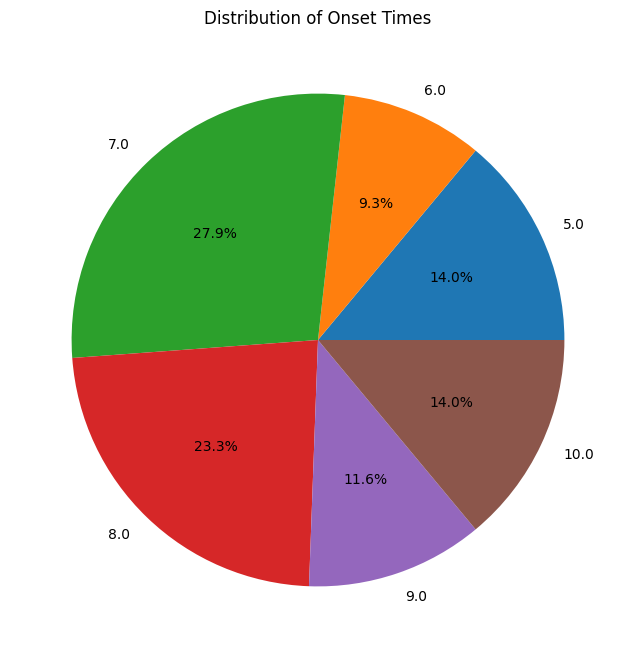

In [31]:
plt.figure(figsize=(8, 8))
wakeup_events['datetime'].dt.hour.value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Onset Times')
plt.ylabel('')
plt.show()

Мне бы так. Большинство готовятся ко сну с 22:00-23:00 и просыпаются в 07:00

#


In [32]:
sample_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 592 entries, 6456 to 14317
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  592 non-null    object        
 1   night      592 non-null    int64         
 2   event      592 non-null    object        
 3   step       86 non-null     float64       
 4   timestamp  86 non-null     object        
 5   datetime   86 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 32.4+ KB


Уберем null

In [33]:
mask_nonull= (~sample_events['step'].isnull()) & (~sample_events['datetime'].isnull()) 
sample_events_nonull = sample_events[mask_nonull]
sample_events_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 6456 to 14229
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  86 non-null     object        
 1   night      86 non-null     int64         
 2   event      86 non-null     object        
 3   step       86 non-null     float64       
 4   timestamp  86 non-null     object        
 5   datetime   86 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 4.7+ KB


In [34]:
sample_events_nonull.series_id.unique()

array(['78569a801a38', 'cfeb11428dd7', 'f564985ab692', 'f56824b503a0',
       'fb223ed2278c'], dtype=object)

In [35]:
sleep_duration_df = (
    sample_events_nonull.groupby(['series_id', 'night'])['datetime']
    .agg([('min', 'min'), ('max', 'max')])
    .reset_index()
)

In [36]:
sleep_duration_df = sleep_duration_df.rename(columns={'min': 'onset', 'max': 'wakeup'})

In [37]:
sleep_duration_df['sleep_duration'] = ((sleep_duration_df['wakeup'] - sleep_duration_df['onset']).dt.seconds / 3600).round(0)

Text(0, 0.5, 'Sleep duration by hours')

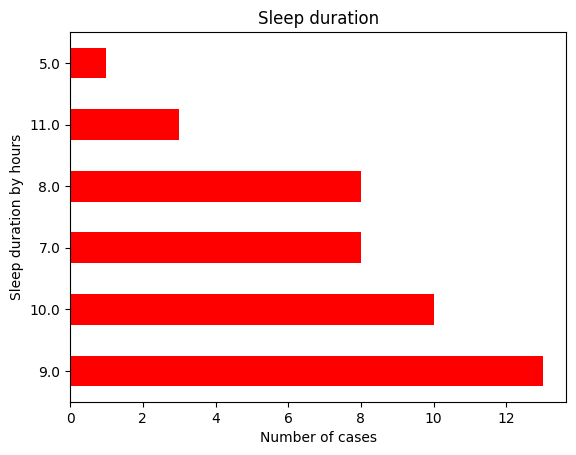

In [38]:
sleep_duration_df['sleep_duration'].value_counts().plot(kind='barh', color='red')
plt.title('Sleep duration')
plt.xlabel('Number of cases')
plt.ylabel('Sleep duration by hours')

Как мы видим, большинство людей спят от 9 до 10 часов. Счастливчики!

# Anglez, Enmo, Onset and Wakeup

* Anglez - это угол наклона руки относительно вертикальной оси тела. 
* ENMO - это евклидова норма минус один из всех сигналов акселерометра.

### Во-первых, давайте объединим два набора данныхПопрбуем рассмотреть для одной series_id, что происходит в разные дни ночи


Во-первых, давайте объединим два набора данных

In [39]:
sample_series = sample_series.to_pandas()

In [40]:
sample_series = sample_series.rename(columns={'timestamp': 'timestamp_series', 'datetime': 'datetime_series'})
sample_events_nonull = sample_events_nonull.rename(columns={'timestamp': 'timestamp_events', 'datetime': 'datetime_events'})

In [55]:
sample_series

,series_id,step,timestamp_series,anglez,enmo,datetime_series
0,78569a801a38,0,2017-08-17T16:45:00-0400,-0.709000,0.0521,2017-08-17 20:45:00
1,78569a801a38,1,2017-08-17T16:45:05-0400,26.159300,0.0415,2017-08-17 20:45:05
2,78569a801a38,2,2017-08-17T16:45:10-0400,-19.055300,0.0312,2017-08-17 20:45:10
3,78569a801a38,3,2017-08-17T16:45:15-0400,-56.735001,0.0486,2017-08-17 20:45:15
4,78569a801a38,4,2017-08-17T16:45:20-0400,-59.033001,0.0350,2017-08-17 20:45:20
...,...,...,...,...,...,...
5061235,fb223ed2278c,918355,2019-02-05T15:29:35-0500,-8.031400,0.0237,2019-02-05 20:29:35
5061236,fb223ed2278c,918356,2019-02-05T15:29:40-0500,-8.215200,0.0229,2019-02-05 20:29:40
5061237,fb223ed2278c,918357,2019-02-05T15:29:45-0500,-7.317400,0.0258,2019-02-05 20:29:45
5061238,fb223ed2278c,918358,2019-02-05T15:29:50-0500,-10.651500,0.0328,2019-02-05 20:29:50


In [54]:
sample_events_nonull

,series_id,night,event,step,timestamp_events,datetime_events
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400,2017-08-19 09:22:00
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400,2017-08-20 03:21:00
...,...,...,...,...,...,...
14219,fb223ed2278c,4,wakeup,65700.0,2018-12-18T07:15:00-0500,2018-12-18 07:15:00
14220,fb223ed2278c,5,onset,75600.0,2018-12-18T21:00:00-0500,2018-12-18 21:00:00
14221,fb223ed2278c,5,wakeup,82944.0,2018-12-19T07:12:00-0500,2018-12-19 07:12:00
14228,fb223ed2278c,9,onset,146772.0,2018-12-22T23:51:00-0500,2018-12-22 23:51:00


In [143]:
sample_series.head(1)

,series_id,step,timestamp_series,anglez,enmo,datetime_series
0,78569a801a38,0,2017-08-17T16:45:00-0400,-0.709,0.0521,2017-08-17 20:45:00


In [142]:

sample_events_nonull.head(1)

,series_id,night,event,step,timestamp_events,datetime_events
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00


Изменяю конкат

In [57]:
sample_events_nonull

,series_id,night,event,step,timestamp_events,datetime_events
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400,2017-08-19 09:22:00
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400,2017-08-20 03:21:00
...,...,...,...,...,...,...
14219,fb223ed2278c,4,wakeup,65700.0,2018-12-18T07:15:00-0500,2018-12-18 07:15:00
14220,fb223ed2278c,5,onset,75600.0,2018-12-18T21:00:00-0500,2018-12-18 21:00:00
14221,fb223ed2278c,5,wakeup,82944.0,2018-12-19T07:12:00-0500,2018-12-19 07:12:00
14228,fb223ed2278c,9,onset,146772.0,2018-12-22T23:51:00-0500,2018-12-22 23:51:00


In [59]:
train_series_complete = sample_series.merge(sample_events_nonull, on=['series_id', 'step'], how='left')


In [61]:
train_series_complete[(train_series_complete['series_id']=='78569a801a38') & (~train_series_complete['event'].isnull())].head(4)

,series_id,step,timestamp_series,anglez,enmo,datetime_series,night,event,timestamp_events,datetime_events
5496,78569a801a38,5496,2017-08-18T00:23:00-0400,-25.705500,0.0779,2017-08-18 04:23:00,1.0,onset,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
13104,78569a801a38,13104,2017-08-18T10:57:00-0400,-53.118599,0.0000,2017-08-18 14:57:00,1.0,wakeup,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
22488,78569a801a38,22488,2017-08-18T23:59:00-0400,52.196602,0.0000,2017-08-19 03:59:00,2.0,onset,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
29244,78569a801a38,29244,2017-08-19T09:22:00-0400,20.395500,0.0000,2017-08-19 13:22:00,2.0,wakeup,2017-08-19T09:22:00-0400,2017-08-19 09:22:00


In [62]:
train_series_complete['datetime'] = train_series_complete['datetime_series'].fillna(train_series_complete['datetime_events'])

In [63]:
train_series_complete[(train_series_complete['series_id']=='78569a801a38') & (~train_series_complete['event'].isnull())].head(4)

,series_id,step,timestamp_series,anglez,enmo,datetime_series,night,event,timestamp_events,datetime_events,datetime
5496,78569a801a38,5496,2017-08-18T00:23:00-0400,-25.705500,0.0779,2017-08-18 04:23:00,1.0,onset,2017-08-18T00:23:00-0400,2017-08-18 00:23:00,2017-08-18 04:23:00
13104,78569a801a38,13104,2017-08-18T10:57:00-0400,-53.118599,0.0000,2017-08-18 14:57:00,1.0,wakeup,2017-08-18T10:57:00-0400,2017-08-18 10:57:00,2017-08-18 14:57:00
22488,78569a801a38,22488,2017-08-18T23:59:00-0400,52.196602,0.0000,2017-08-19 03:59:00,2.0,onset,2017-08-18T23:59:00-0400,2017-08-18 23:59:00,2017-08-19 03:59:00
29244,78569a801a38,29244,2017-08-19T09:22:00-0400,20.395500,0.0000,2017-08-19 13:22:00,2.0,wakeup,2017-08-19T09:22:00-0400,2017-08-19 09:22:00,2017-08-19 13:22:00


In [64]:
train_series_complete[(train_series_complete['series_id']=='78569a801a38')].head(4)

,series_id,step,timestamp_series,anglez,enmo,datetime_series,night,event,timestamp_events,datetime_events,datetime
0,78569a801a38,0,2017-08-17T16:45:00-0400,-0.709000,0.0521,2017-08-17 20:45:00,NaN,NaN,NaN,NaT,2017-08-17 20:45:00
1,78569a801a38,1,2017-08-17T16:45:05-0400,26.159300,0.0415,2017-08-17 20:45:05,NaN,NaN,NaN,NaT,2017-08-17 20:45:05
2,78569a801a38,2,2017-08-17T16:45:10-0400,-19.055300,0.0312,2017-08-17 20:45:10,NaN,NaN,NaN,NaT,2017-08-17 20:45:10
3,78569a801a38,3,2017-08-17T16:45:15-0400,-56.735001,0.0486,2017-08-17 20:45:15,NaN,NaN,NaN,NaT,2017-08-17 20:45:15


In [66]:
train_series_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061240 entries, 0 to 5061239
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   series_id         object        
 1   step              uint32        
 2   timestamp_series  object        
 3   anglez            float32       
 4   enmo              float32       
 5   datetime_series   datetime64[us]
 6   night             float64       
 7   event             object        
 8   timestamp_events  object        
 9   datetime_events   datetime64[ns]
 10  datetime          datetime64[us]
dtypes: datetime64[ns](1), datetime64[us](2), float32(2), float64(1), object(4), uint32(1)
memory usage: 366.8+ MB


In [67]:
train_series_complete.drop(columns=['timestamp_series', 'datetime_series', 'timestamp_events', 'datetime_events'], inplace=True)

In [68]:
train_series_complete

,series_id,step,anglez,enmo,night,event,datetime
0,78569a801a38,0,-0.709000,0.0521,NaN,NaN,2017-08-17 20:45:00
1,78569a801a38,1,26.159300,0.0415,NaN,NaN,2017-08-17 20:45:05
2,78569a801a38,2,-19.055300,0.0312,NaN,NaN,2017-08-17 20:45:10
3,78569a801a38,3,-56.735001,0.0486,NaN,NaN,2017-08-17 20:45:15
4,78569a801a38,4,-59.033001,0.0350,NaN,NaN,2017-08-17 20:45:20
...,...,...,...,...,...,...,...
5061235,fb223ed2278c,918355,-8.031400,0.0237,NaN,NaN,2019-02-05 20:29:35
5061236,fb223ed2278c,918356,-8.215200,0.0229,NaN,NaN,2019-02-05 20:29:40
5061237,fb223ed2278c,918357,-7.317400,0.0258,NaN,NaN,2019-02-05 20:29:45
5061238,fb223ed2278c,918358,-10.651500,0.0328,NaN,NaN,2019-02-05 20:29:50


In [69]:
train_series_complete = train_series_complete.sort_values(by='datetime', ascending=True).reset_index()

In [70]:
train_series_complete[~train_series_complete['event'].isnull()]

,index,series_id,step,anglez,enmo,night,event,datetime
5496,5496,78569a801a38,5496,-25.705500,0.0779,1.0,onset,2017-08-18 04:23:00
13104,13104,78569a801a38,13104,-53.118599,0.0000,1.0,wakeup,2017-08-18 14:57:00
22488,22488,78569a801a38,22488,52.196602,0.0000,2.0,onset,2017-08-19 03:59:00
29244,29244,78569a801a38,29244,20.395500,0.0000,2.0,wakeup,2017-08-19 13:22:00
42192,42192,78569a801a38,42192,-53.506802,0.0000,3.0,onset,2017-08-20 07:21:00
...,...,...,...,...,...,...,...,...
3532680,2394900,f564985ab692,151200,-65.067902,0.0000,9.0,wakeup,2018-12-31 13:45:00
3694489,2475804,f564985ab692,232104,41.042702,0.1199,14.0,onset,2019-01-05 06:07:00
3707641,2482380,f564985ab692,238680,31.995501,0.0000,14.0,wakeup,2019-01-05 15:15:00
3900720,2578920,f564985ab692,335220,-38.461399,0.0048,20.0,onset,2019-01-11 05:20:00


### Берем series_id. Для конкретной даты (2017-08-18) и для конкретной серии (78569a801a38) давайте построим anglez, enmo, onset и wakeup


In [71]:
random_series_id = '78569a801a38'
random_date = '2017-08-18'
train_series_random_case = train_series_complete[
    (train_series_complete['series_id'] == random_series_id) & 
    (train_series_complete['datetime'].dt.date == pd.to_datetime(random_date).date())]

In [72]:
train_series_random_case

,index,series_id,step,anglez,enmo,night,event,datetime
2340,2340,78569a801a38,2340,-25.307400,0.0939,NaN,NaN,2017-08-18 00:00:00
2341,2341,78569a801a38,2341,-43.852798,0.1241,NaN,NaN,2017-08-18 00:00:05
2342,2342,78569a801a38,2342,-8.639700,0.0668,NaN,NaN,2017-08-18 00:00:10
2343,2343,78569a801a38,2343,-13.022500,0.0700,NaN,NaN,2017-08-18 00:00:15
2344,2344,78569a801a38,2344,-18.604900,0.5286,NaN,NaN,2017-08-18 00:00:20
...,...,...,...,...,...,...,...,...
19615,19615,78569a801a38,19615,-73.487297,0.0335,NaN,NaN,2017-08-18 23:59:35
19616,19616,78569a801a38,19616,-68.729897,0.0354,NaN,NaN,2017-08-18 23:59:40
19617,19617,78569a801a38,19617,-21.297400,0.0417,NaN,NaN,2017-08-18 23:59:45
19618,19618,78569a801a38,19618,19.112801,0.0317,NaN,NaN,2017-08-18 23:59:50


In [74]:
onset_events = train_series_random_case[train_series_random_case['event'] == 'onset']
wakeup_events = train_series_random_case[train_series_random_case['event'] == 'wakeup']


In [75]:
wakeup_events

,index,series_id,step,anglez,enmo,night,event,datetime
13104,13104,78569a801a38,13104,-53.118599,0.0,1.0,wakeup,2017-08-18 14:57:00


In [76]:
onset_events

,index,series_id,step,anglez,enmo,night,event,datetime
5496,5496,78569a801a38,5496,-25.7055,0.0779,1.0,onset,2017-08-18 04:23:00


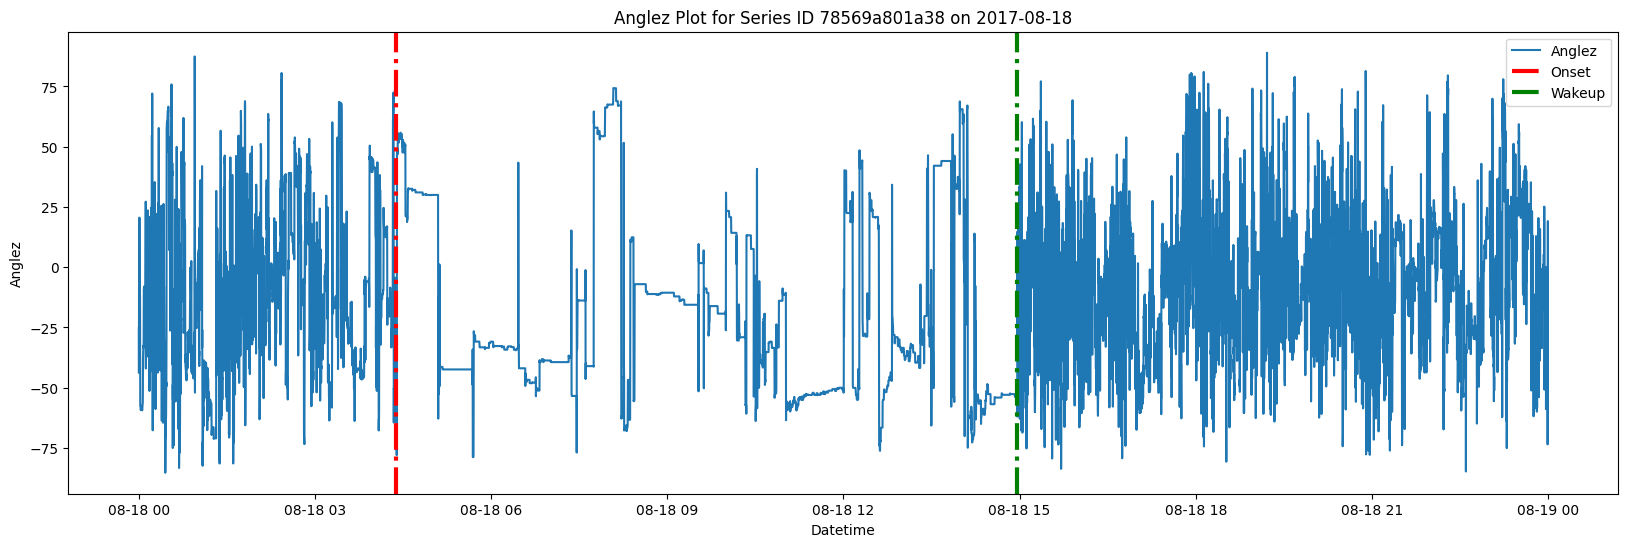

In [79]:
plt.figure(figsize=(20, 6))
plt.plot(train_series_random_case['datetime'], train_series_random_case['anglez'], label='Anglez', linestyle='solid')

onset_legend_added = False
wakeup_legend_added = False

# Add dashed lines for 'onset' and 'wakeup' events
for onset in onset_events['datetime']:
    plt.axvline(x=onset, color='r', linestyle='dashdot', linewidth=3, label='Onset' if not onset_legend_added else '_nolegend_')
    onset_legend_added = True

    
for wakeup in wakeup_events['datetime']:
    plt.axvline(x=wakeup, color='g', linestyle='dashdot', linewidth=3, label='Wakeup' if not wakeup_legend_added else '_nolegend_')
    wakeup_legend_added = True

# Customize the plot
plt.xlabel('Datetime')
plt.ylabel('Anglez')
plt.title(f'Anglez Plot for Series ID {random_series_id} on {random_date}')
plt.legend()

plt.show()

Теперь давайте посмотрим на enmo



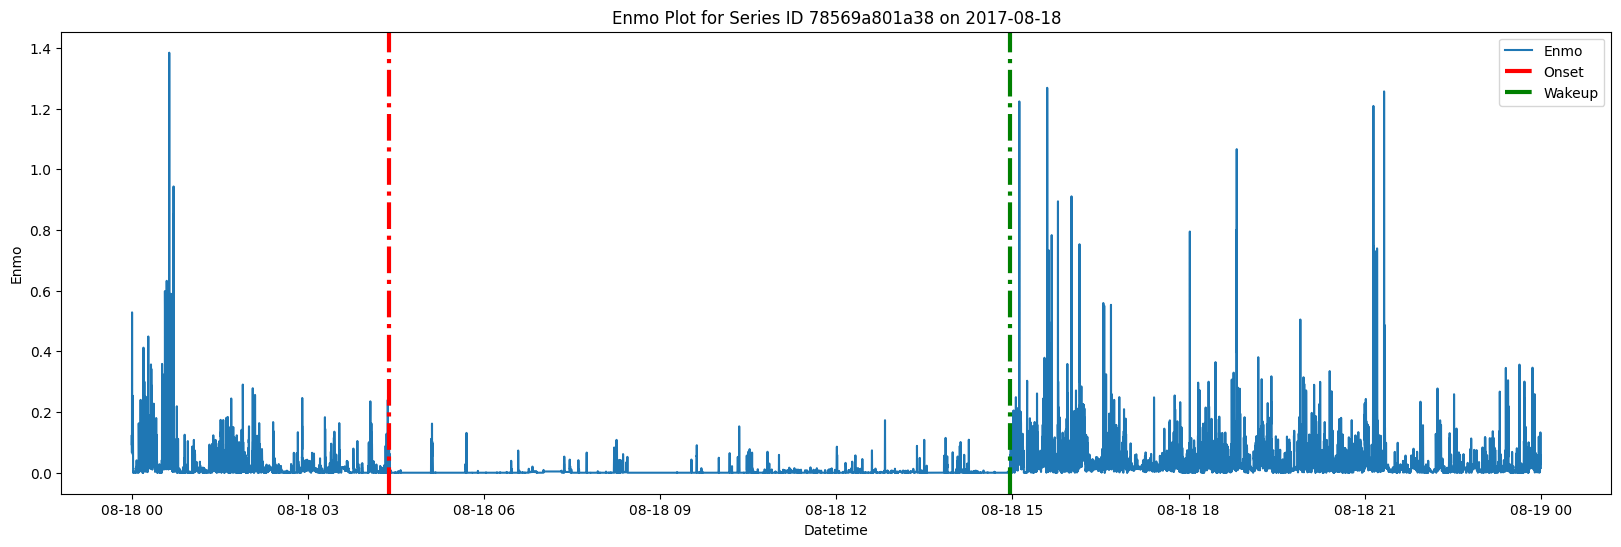

In [80]:
plt.figure(figsize=(20, 6))
plt.plot(train_series_random_case['datetime'], train_series_random_case['enmo'], label='Enmo', linestyle='solid')

onset_legend_added = False
wakeup_legend_added = False

# Add dashed lines for 'onset' and 'wakeup' events
for onset in onset_events['datetime']:
    plt.axvline(x=onset, color='r', linestyle='dashdot', linewidth=3, label='Onset' if not onset_legend_added else '_nolegend_')
    onset_legend_added = True

for wakeup in wakeup_events['datetime']:
    plt.axvline(x=wakeup, color='g', linestyle='dashdot', linewidth=3, label='Wakeup' if not wakeup_legend_added else '_nolegend_')
    wakeup_legend_added = True

# Customize the plot
plt.xlabel('Datetime')
plt.ylabel('Enmo')
plt.title(f'Enmo Plot for Series ID {random_series_id} on {random_date}')
plt.legend()

plt.show()

Как мы видим, как для Angles, так и для Enmo, структура значений сильно меняется.

In [91]:
random_series_id = '78569a801a38'
random_train_series_events = train_series_complete[(train_series_complete['series_id'] == random_series_id)]

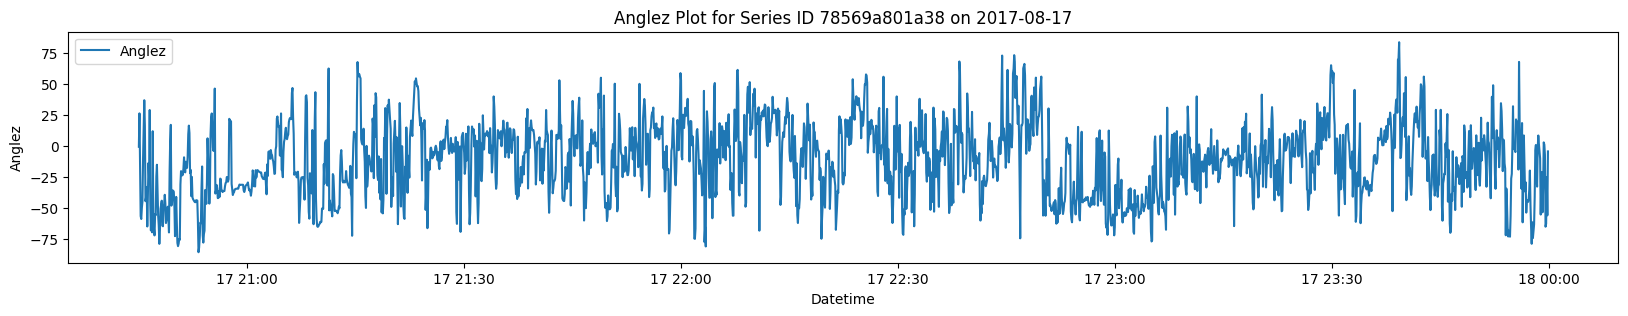

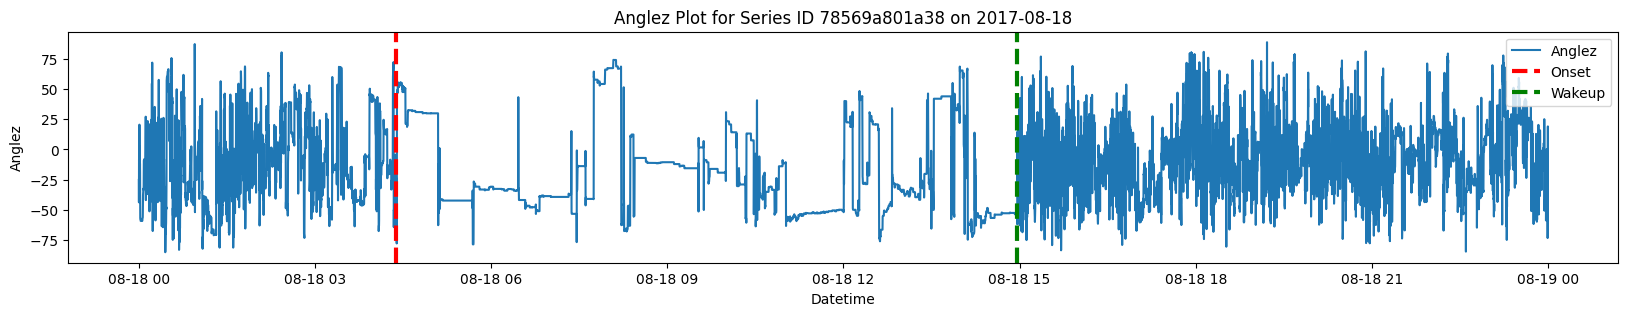

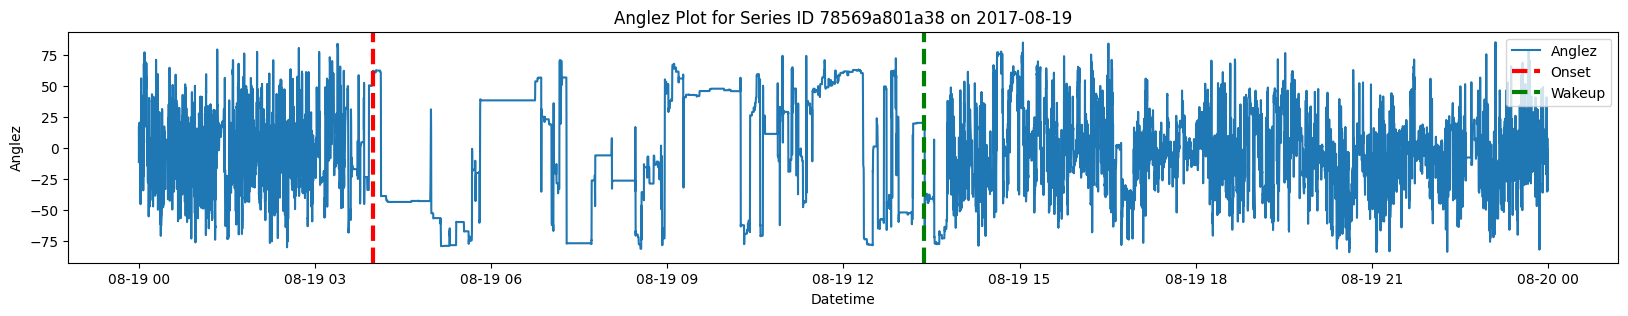

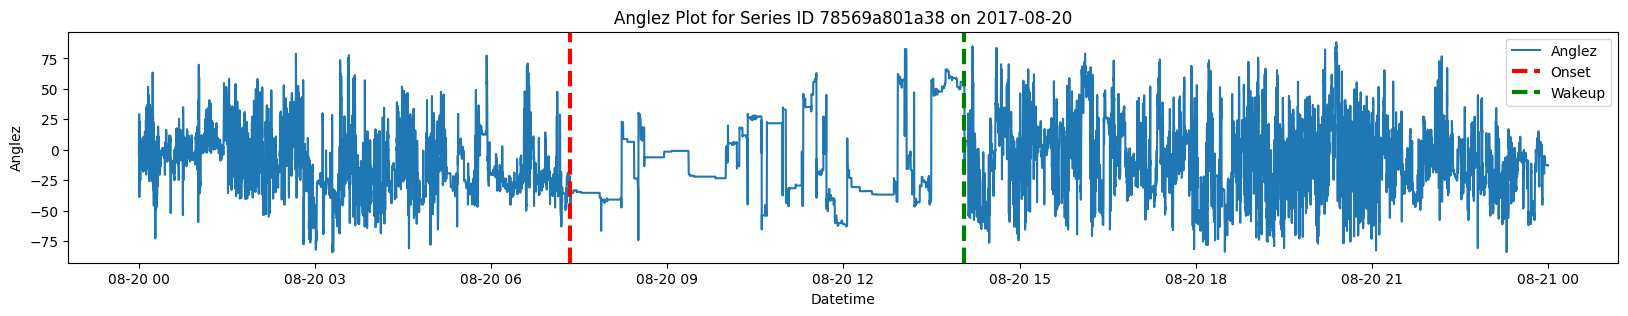

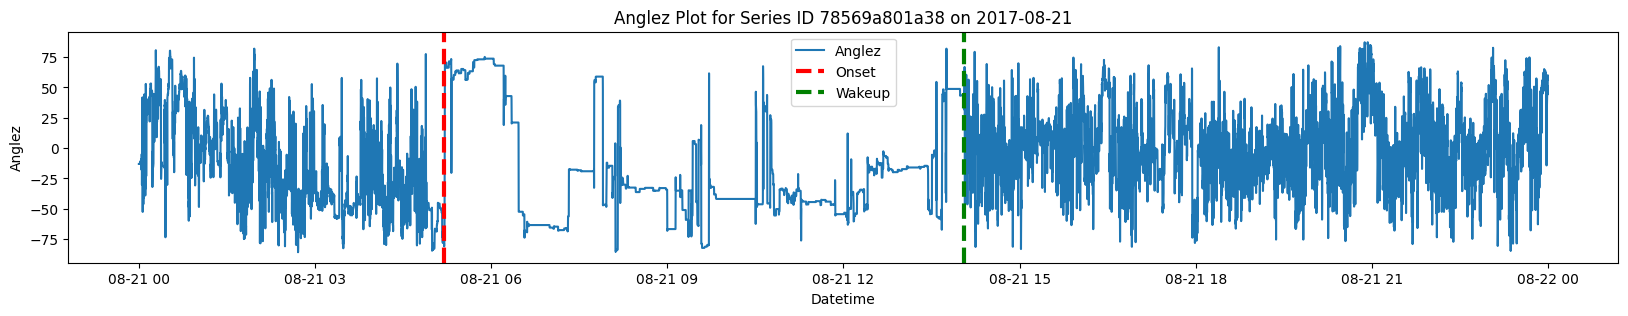

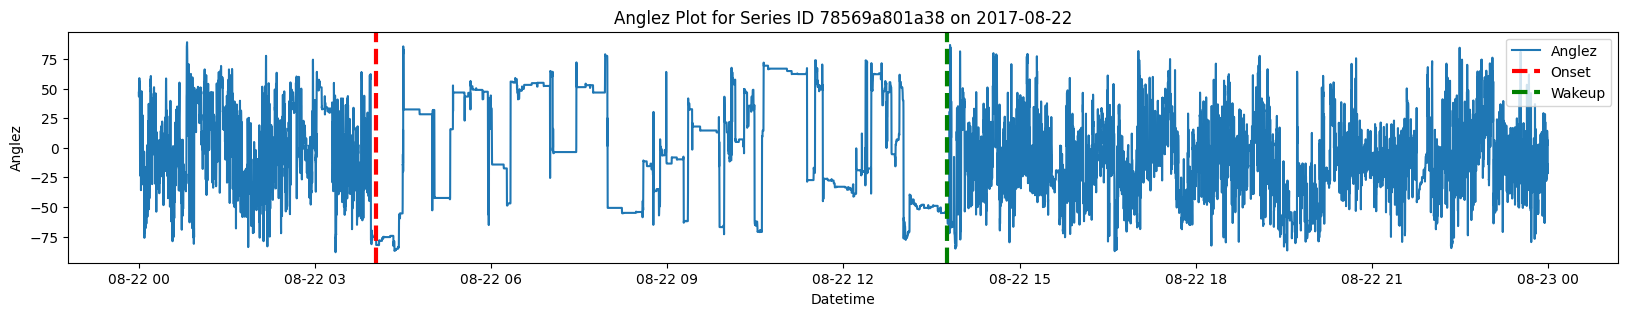

In [92]:
for d in random_train_series_events['datetime'].dt.date.unique()[0:6]:
    random_train_series_events_date = random_train_series_events[random_train_series_events['datetime'].dt.date==d]
    
    # Create the line chart
    plt.figure(figsize=(20, 3))
    plt.plot(random_train_series_events_date['datetime'], random_train_series_events_date['anglez'], label='Anglez', linestyle='solid')
    
    onset_events_on_specific_date = random_train_series_events_date[random_train_series_events_date['event'] == 'onset']
    wakeup_events_on_specific_date = random_train_series_events_date[random_train_series_events_date['event'] == 'wakeup']

    onset_legend_added = False
    wakeup_legend_added = False

    # Add dashed lines for 'onset' and 'wakeup' events
    for onset in onset_events_on_specific_date['datetime']:
        plt.axvline(x=onset, color='r', linestyle='--', linewidth=3, label='Onset' if not onset_legend_added else '_nolegend_')
        onset_legend_added = True

    for wakeup in wakeup_events_on_specific_date['datetime']:
        plt.axvline(x=wakeup, color='g', linestyle='--', linewidth=3, label='Wakeup' if not wakeup_legend_added else '_nolegend_')
        wakeup_legend_added = True

    # Customize the plot
    plt.xlabel('Datetime')
    plt.ylabel('Anglez')
    plt.title(f'Anglez Plot for Series ID {random_series_id} on {d}')
    plt.legend()

    plt.show()
    
    


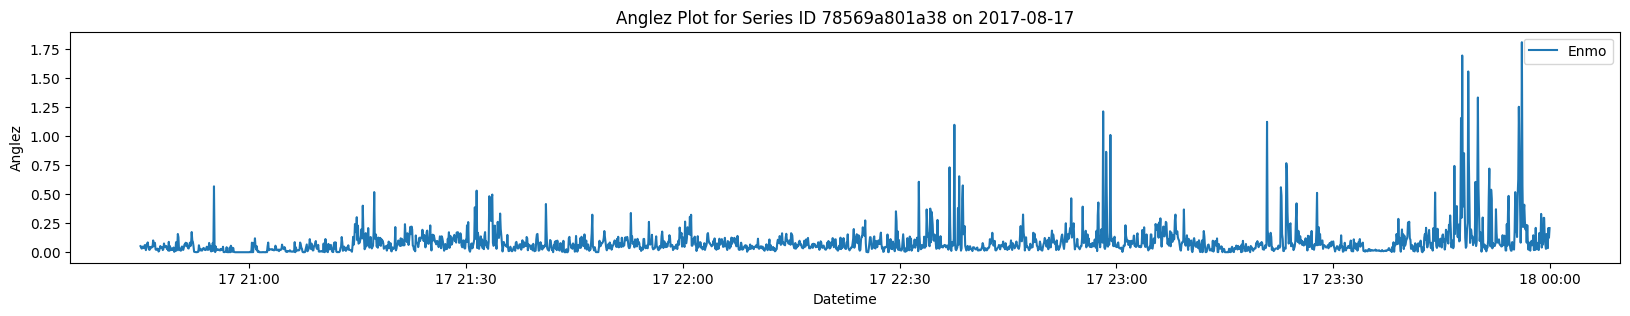

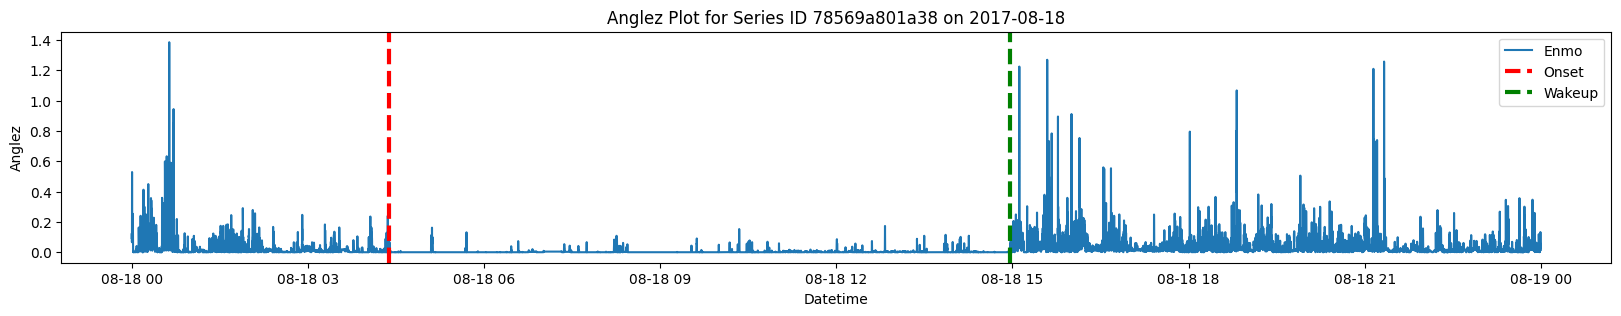

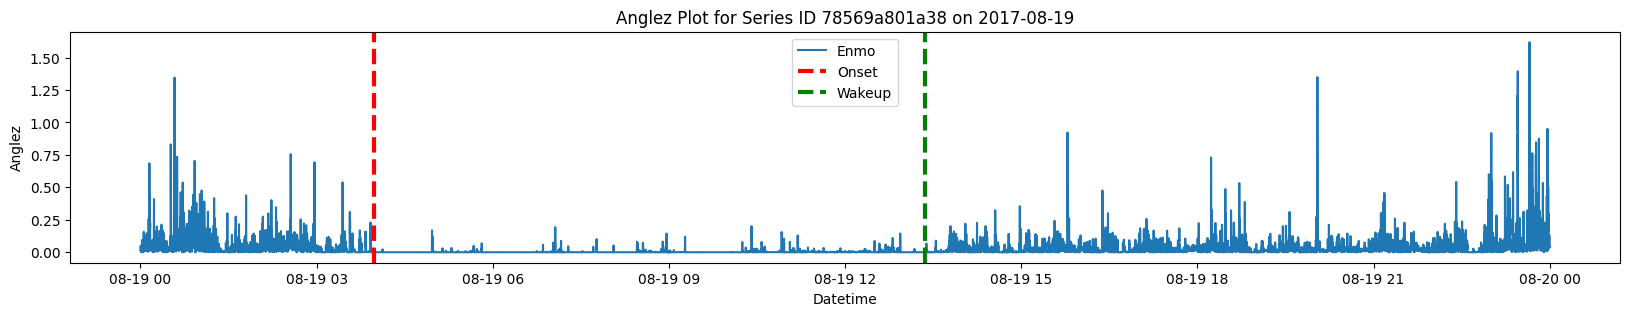

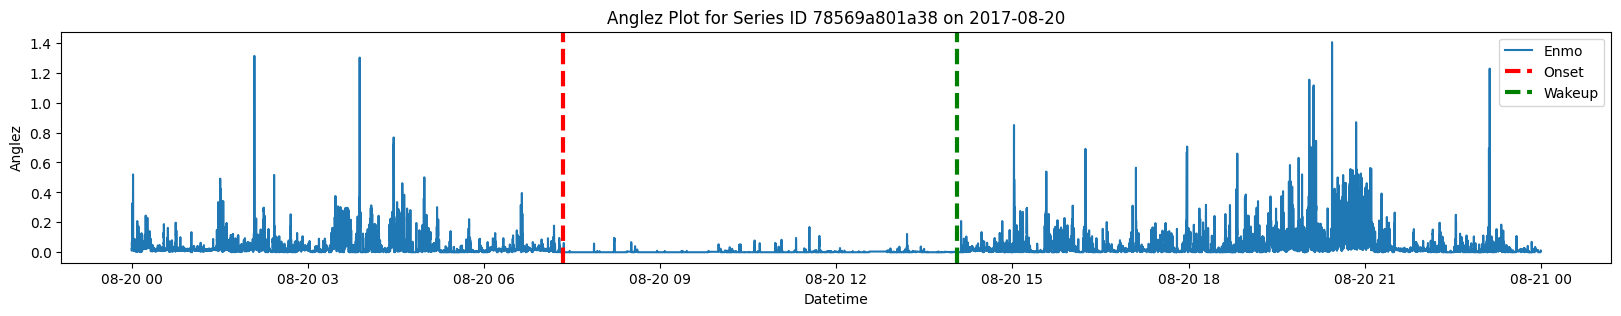

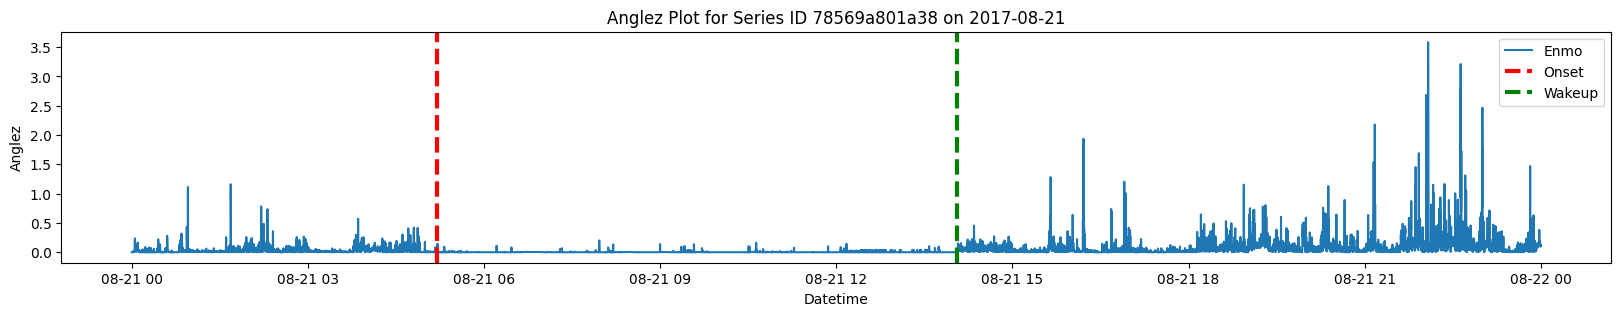

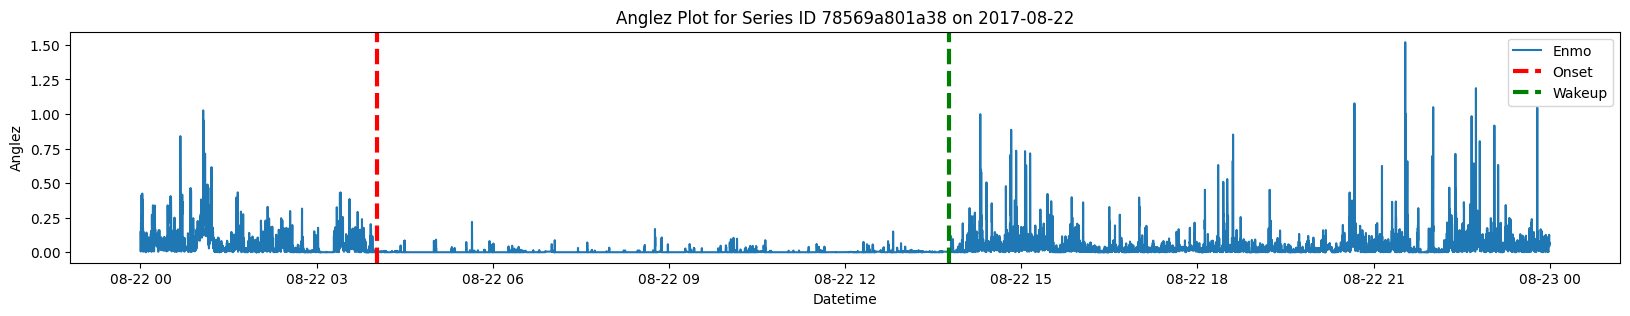

In [93]:
for d in random_train_series_events['datetime'].dt.date.unique()[0:6]:
    random_train_series_events_date = random_train_series_events[random_train_series_events['datetime'].dt.date==d]
    
    # Create the line chart
    plt.figure(figsize=(20, 3))
    plt.plot(random_train_series_events_date['datetime'], random_train_series_events_date['enmo'], label='Enmo', linestyle='solid')
    
    onset_events_on_specific_date = random_train_series_events_date[random_train_series_events_date['event'] == 'onset']
    wakeup_events_on_specific_date = random_train_series_events_date[random_train_series_events_date['event'] == 'wakeup']

    onset_legend_added = False
    wakeup_legend_added = False

    # Add dashed lines for 'onset' and 'wakeup' events
    for onset in onset_events_on_specific_date['datetime']:
        plt.axvline(x=onset, color='r', linestyle='--', linewidth=3, label='Onset' if not onset_legend_added else '_nolegend_')
        onset_legend_added = True

    for wakeup in wakeup_events_on_specific_date['datetime']:
        plt.axvline(x=wakeup, color='g', linestyle='--', linewidth=3, label='Wakeup' if not wakeup_legend_added else '_nolegend_')
        wakeup_legend_added = True

    # Customize the plot
    plt.xlabel('Datetime')
    plt.ylabel('Anglez')
    plt.title(f'Anglez Plot for Series ID {random_series_id} on {d}')
    plt.legend()

    plt.show()
    
    
